 <h1><center> Проект для оператора связи «Ниединогоразрыва.ком»</center></h1>

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).
Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично, название и описание на месте!</div>

**План выполнения проекта**

1. Предобработка данных  
   1.1. Загрузка данных  
   1.2. Предварительны анализ данных  
   1.3. Объединение в единый фрейм, изучение полученных данных, определение возможных причин пропусков  
2. Исследовательский анализ данных, подготовка данных к расчету модели: удаление неинформативных признаков, кодирование категориальных переменных
3. Обучение моделей: подготовка выборок для обучения, подбор гиперпараметров
4. Проверка качества моделей на кросс-валидации, определение на тестовой выборке метрики AUC-ROC для лучшей модели, изучение важности признаков лучшей модели
5. Общий вывод

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Хороший план!</div>

## Предобработка данных

### Импортируем необходимые библиотеки 

In [2]:
!pip install phik
!pip install matplotlib --upgrade

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import phik

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import math
import warnings
warnings.filterwarnings('ignore')

In [4]:
root = 'C:/Users/orkha/Downloads/final_provider/final_provider/'
rs = 270223

### Загрузим данные 

In [5]:
try:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    df_contract = pd.read_csv(root + 'contract.csv')
    df_internet = pd.read_csv(root + 'internet.csv')
    df_personal = pd.read_csv(root + 'personal.csv')
    df_phone = pd.read_csv(root + 'phone.csv')

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Ок, данные на базе!</div>

Создадим функцию для предварительного анализа

In [6]:
def eda(data):
    display(data.head())
    display(data.tail())
    data.info()
    display(data.describe())
    

Проведем предварительный анализ данных

In [7]:
eda(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,6844.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<div class="alert alert-block alert-info">
Как видим из анализа, численных признаков всего 1 - столбец MonthlyCharges.    
Среднее значение и медиана столбца примерно одинакова, из этого можно сделать вывод, что данные распределены нормально, с небольшими выбросами.  Более подробно изучим признак в части исследовательского анализа данных.  
Столбец TotalCharges должен относится к численным признакам, однако имеет тип данных 'object'. Необходимо изменить тип данного столбца.  
В таблице 7043 строк и 8 столбцев.  
Столбец customerID имеет уникальные значения.</div>

In [8]:
eda(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<div class="alert alert-block alert-info">
Таблица имеет 5517 строк и 8 столбцов.  
Столбец customerID имеет уникальные значения, а остальные столбцы в формате 'object' показывают, подключена ли услуга у клиента или нет. 
</div>


In [9]:
eda(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<div class="alert alert-block alert-info">
Таблица рассказывает нам о персональных данных клиентов.  
В тот части пол клиента, семейное положение, наличие иждивенцов в формате 'object'.  
Столбец SeniorCitizen имеет бинарную классификацию и показывает о наличии пенсионного статуса (1) или его отсутсвии (0).  
При предварительном анализе видно, что большинство клиентов не имеет пенсионного статуса. Более подробно изучим признак в части исследовательского анализа данных
</div>

In [10]:
eda(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


<div class="alert alert-block alert-info">
Таблица рассказывает о наличии возможности введения параллельных линий у клиента. Имеет 6361 строк и 2 столбца с уникальными значениями id клиентов (customerID) и наличие такой возможности
</div>

**Описание столбцов**

* customerID - уникальный идентификатор пользователя
* BeginDate - дата начала использования услуг компании
* EndDate - дата окончания использования услуг компании
* Type - тип внесения платы: ежемесячно /раз в год/ раз в два года
* PaperlessBilling - электронный платежный документ
* PaymentMethod - способ оплаты
* MonthlyCharges - ежемесячные платежи за услугу
* TotalCharges - сумма всех платежей
* gender - пол клиента
* SeniorCitizen - пенсионного статуса
* Partner - семейное положение
* Dependents - наличие иждивенцев
* InternetService - тип подключения
* Столбцы OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines показывают - подключена ли услуга: Yes/No.

Вопросов нет благодаря вебинару и общему чату, все данные и описание их понятны.

### Исследовательский анализ данных

Соединим выборки в единый DataFrame

In [11]:
data = df_contract.merge(df_personal, how='outer', on='customerID').merge(df_internet, how='outer', on='customerID').merge(df_phone, how='outer', on='customerID')
data.sample(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2307,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,593.3,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
449,1090-ESELR,2014-02-01,No,Two year,No,Bank transfer (automatic),105.5,7611.55,Male,0,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,No
5619,4619-EVPHY,2018-06-01,No,One year,Yes,Bank transfer (automatic),91.0,1859.5,Female,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,No


In [12]:
data.duplicated().sum()

0

Дубликатов в таблице нет, объединение прошло удачно

In [13]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Как видим появились пропуски из-за объединения таблиц с различной размерностью

In [14]:
def show_rows(data):
    for column in data.columns:
        print('Уникальные значения столбца', column)
        print(data[column].sort_values().unique()) 

In [15]:
show_rows(data)

Уникальные значения столбца customerID
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
Уникальные значения столбца BeginDate
['2013-10-01' '2013-11-01' '2013-12-01' '2014-01-01' '2014-02-01'
 '2014-03-01' '2014-04-01' '2014-05-01' '2014-06-01' '2014-07-01'
 '2014-08-01' '2014-09-01' '2014-10-01' '2014-11-01' '2014-12-01'
 '2015-01-01' '2015-02-01' '2015-03-01' '2015-04-01' '2015-05-01'
 '2015-06-01' '2015-07-01' '2015-08-01' '2015-09-01' '2015-10-01'
 '2015-11-01' '2015-12-01' '2016-01-01' '2016-02-01' '2016-03-01'
 '2016-04-01' '2016-05-01' '2016-06-01' '2016-07-01' '2016-08-01'
 '2016-09-01' '2016-10-01' '2016-11-01' '2016-12-01' '2017-01-01'
 '2017-02-01' '2017-03-01' '2017-04-01' '2017-05-01' '2017-06-01'
 '2017-07-01' '2017-08-01' '2017-09-01' '2017-10-01' '2017-11-01'
 '2017-12-01' '2018-01-01' '2018-02-01' '2018-03-01' '2018-04-01'
 '2018-05-01' '2018-06-01' '2018-07-01' '2018-08-01' '2018-09-01'
 '2018-10-01' '2018-11-01' '2018-12-01' '2019-

Как видим из анализа, договора в компании начали заключаться с 2013 года, а рассторгаться только 2019 году. Также видно, что в стобце TotalCharges есть пустые строчки

#### Заполним пропуски 

Для начала рассмотрим появление пустых значений в столбце TotalCharges

In [16]:
data.loc[data['TotalCharges'] == ' ']


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


Как видно из анализа, данные отсутствуют, так как это первый месяц предоставления услуг.  
Заполним пропуски, подставив значения столбца MonthlyCharges

In [17]:
data.loc[(data.TotalCharges == ' '), 'TotalCharges'] = data['MonthlyCharges']


In [18]:
data.sample()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4815,9565-JSNFM,2016-08-01,2019-10-01 00:00:00,One year,Yes,Bank transfer (automatic),70.45,2597.6,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Оставшиеся столбцы заполним значением "No", так как эти клиенты не пользуются этими услгами

In [20]:
col = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [21]:
for i in col:
    data[i].fillna('No', inplace=True)

#### Создадим целевой признак для нашей модели

In [22]:
def termination(df):
    try:
        if df['EndDate'] == 'No':
            return 0
        else:
            return 1
    except:
        pass

In [23]:
data['termination'] = data.apply(termination, axis=1)

Поменяем тип данных в столбцах для последующего использования

In [24]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [25]:
data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')

In [26]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format='%Y-%m-%d')
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [27]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,termination
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,1


#### Проведем визуализацию данных для более наглядного анализа

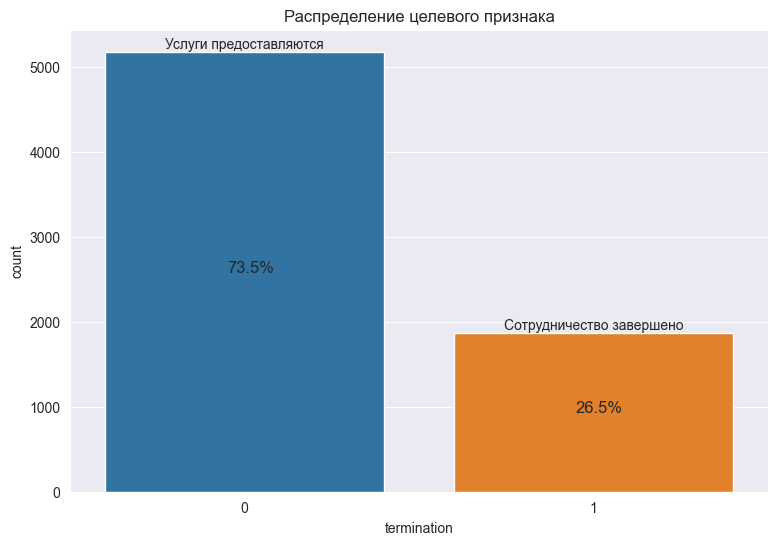

In [28]:
labels = ['Услуги предоставляются', 'Сотрудничество завершено']
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() / 2 - 2
        ax.annotate(percentage, (x, y), size = 12)
        
plt.figure(figsize=(9, 6))

sns.set_style('darkgrid')
ax = sns.countplot(x="termination",  data=data)



without_hue(ax, data.termination)
ax.bar_label(container=ax.containers[0], labels=labels)
ax.set_title('Распределение целевого признака')
plt.show()

<div class="alert alert-block alert-info">
Как видно из графика, в данных присутствует дисбаланс классов  
Более 70% клиентов продолжают пользоваться услугами компании
</div>

Рассмотрим распредение клиентов по половому признаку

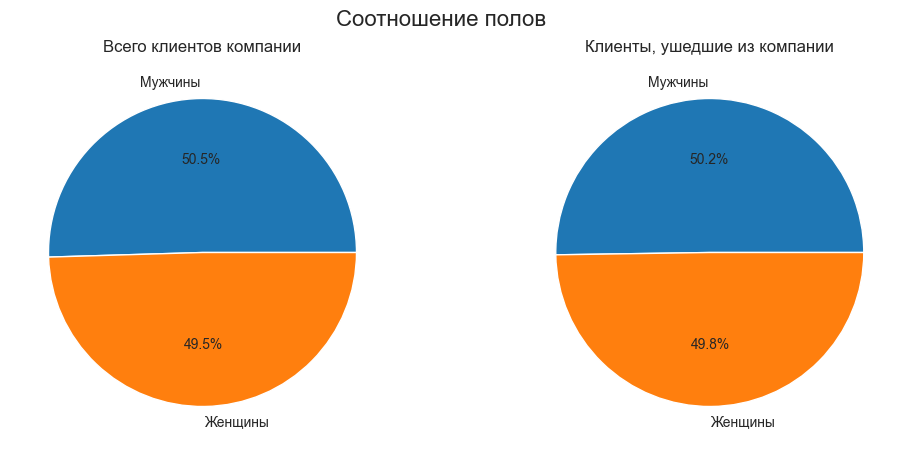

In [29]:
labels = ['Мужчины', 'Женщины']
size = data['gender'].value_counts().values
sizes_2 = data.loc[data['termination'] == 1, 'gender'].value_counts().values
fig, axs = plt.subplots(1,2,
                      figsize=(12,5),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[3,3]))
fig.suptitle("Соотношение полов", fontsize=16)
axs[0].set_title("Всего клиентов компании")
axs[0].pie(size, labels=labels, autopct='%1.1f%%')
axs[1].set_title("Клиенты, ушедшие из компании")
axs[1].pie(sizes_2, labels=labels, autopct='%1.1f%%')
plt.show()



<div class="alert alert-block alert-info">
Как видим соотношение полов всех клиентов и ушедших одинаково. Пол не влияет на поведение пользователей услуг компании
</div>

Добавим пользовательские услуги, для наглядной визуализации, какими услугами пользуются клиенты

In [30]:
data['service'] = 'all'
data.loc[(data['InternetService'] != 'No') & (data['customerID'].isin(df_phone['customerID'])), 'service'] = 'internet'
data.loc[(data['InternetService'] == 'No') & (data['customerID'].isin(df_phone['customerID'])), 'service'] = 'phone'

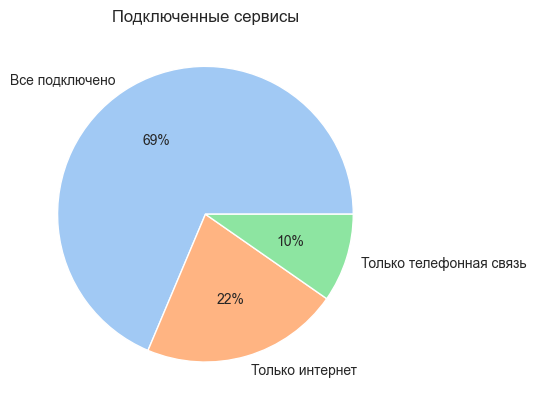

In [31]:
plt.style.use('seaborn-darkgrid')
sizes = data['service'].value_counts().values

labels = ['Все подключено', 'Только интернет', 'Только телефонная связь']

colors = sns.color_palette('pastel')[ 0:5 ]
plt.title('Подключенные сервисы')
plt.pie(sizes, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

<div class="alert alert-block alert-info">
Как видно из графика у большинства (70%) клиентов подключены все услуги. 22% пользователей используют только интернет, а 10% пользуются только мобильно связью
</div>

Создадим столбец с количеством дней пользолвания услуг компании

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [33]:
data['duration_day'] = (data['EndDate'] - data['BeginDate']).dt.days

In [34]:
data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,termination,service,duration_day
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,No,0,all,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,No,0,internet,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,No,1,internet,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,No,0,all,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,No,1,internet,61
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Female,0,...,No,No,Yes,No,Yes,Yes,Yes,1,internet,245
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Male,0,...,No,Yes,No,No,Yes,No,Yes,0,internet,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,Female,0,...,Yes,No,No,No,No,No,No,0,all,306
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,...,No,No,Yes,Yes,Yes,Yes,Yes,1,internet,853
9,6388-TABGU,2014-12-01,2020-02-01,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,...,Yes,Yes,No,No,No,No,No,0,internet,1888


Проанализируем потраченные средства клиентов, и определим возможные причины уходы из компании

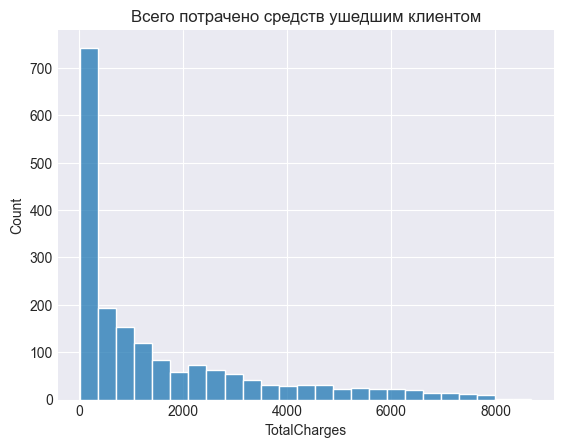

In [35]:
plt.title("Всего потрачено средств ушедшим клиентом")
sns.histplot(data['TotalCharges'].where(data['termination'] == 1))
plt.show()

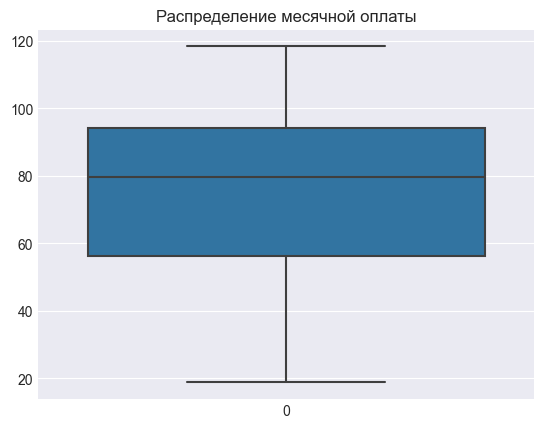

In [36]:
sns.boxplot(data['MonthlyCharges'].where(data['termination'] == 1))
plt.title("Распределение месячной оплаты")
plt.show()    

<div class="alert alert-block alert-info">
Как видно из графика, большинство ушедших пользователей оплачивали услуги, но потом прекращали.    
Ящик с усами показывает, что основная масса клиентов платили за месяц от 70 до 100 средств.    
Сравним этот показатель с данными пользователей, оставшихся пользоваться услугами
</div>

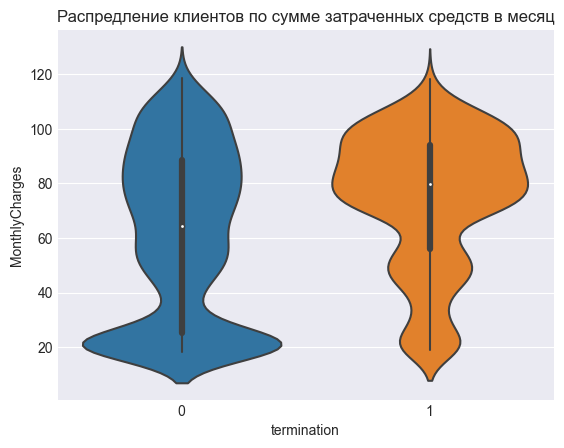

In [37]:
ax = sns.violinplot(x=data['termination'], y=data['MonthlyCharges'])
plt.title('Распредление клиентов по сумме затраченных средств в месяц')
plt.show()

<div class="alert alert-block alert-info">
Теория подтвердилась. Большинство клиентов, продолжающие пользоваться услугами компании платят 20 средств, в отличии от прекративших пользоваться, оплата услуг которых у большинства от 70 до 100 
</div>

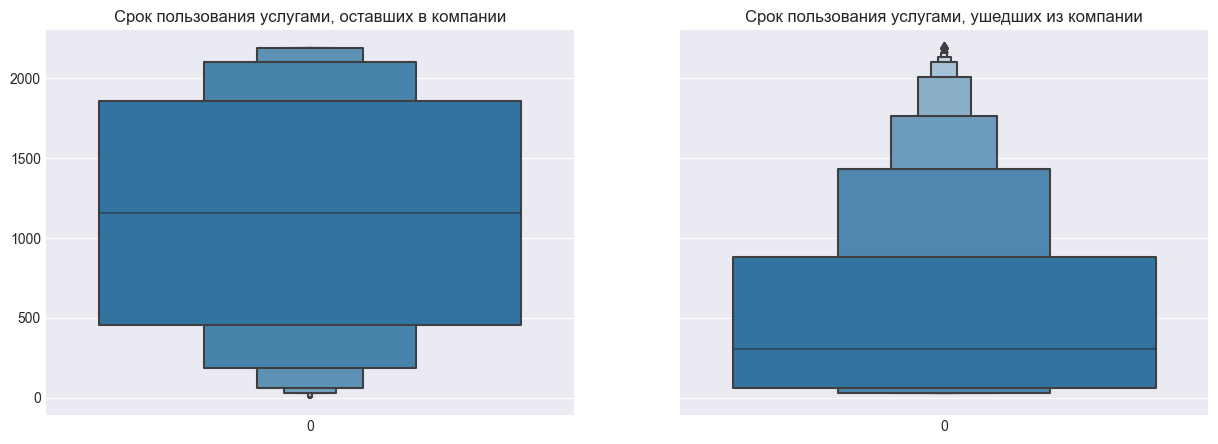

In [38]:
fig, axs = plt.subplots(1,2,
                      figsize=(15,5),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[3,3]))
axs[0].set_title("Срок пользования услугами, оставших в компании")
sns.boxenplot(data['duration_day'].where(data['termination'] == 0), ax=axs[0])
axs[1].set_title("Срок пользования услугами, ушедших из компании")
sns.boxenplot(data['duration_day'].where(data['termination'] == 1), ax=axs[1])
plt.show()


<div class="alert alert-block alert-info">
Как видно из графиков, большинство клиентов, прекративших пользовться услугами, уходили в первые 2 года. Вероятно это из-за высокой платы за месяц
</div>

Рассмотрим распределение типов оплаты: общую, прервавших сотрудничество и продолжающих пользоваться услугами клиентами

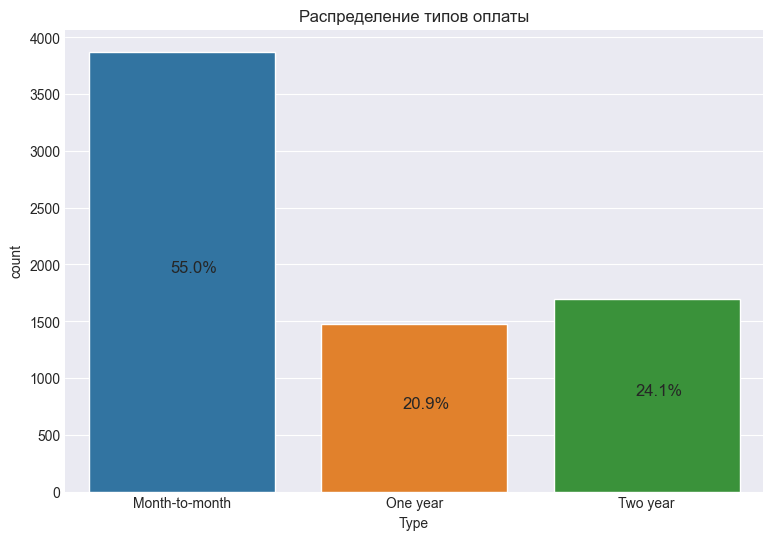

In [39]:
def without_hue_1(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height() / 2 - 2
        ax.annotate(percentage, (x, y), size = 12)
        
plt.figure(figsize=(9, 6))

sns.set_style('darkgrid')
ax2 = sns.countplot(x="Type",  data=data)



without_hue_1(ax2, data.Type)

ax2.set_title('Распределение типов оплаты')
plt.show()

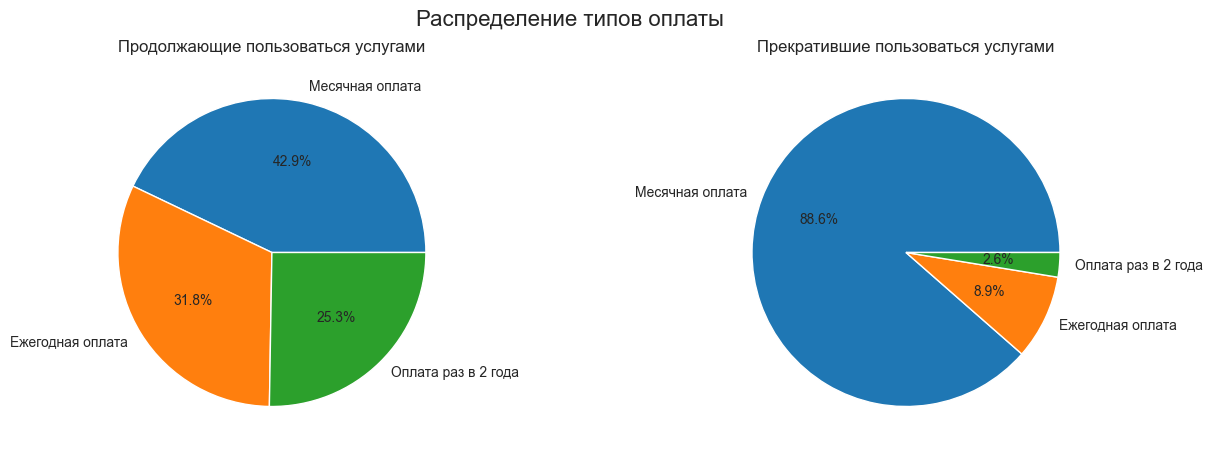

In [40]:
labels_2 = ["Месячная оплата", "Ежегодная оплата", "Оплата раз в 2 года"]
sizes_3 = data.loc[data['termination'] == 0, 'Type'].value_counts().values
sizes_4 = data.loc[data['termination'] == 1, 'Type'].value_counts().values
fig_1, axs_1 = plt.subplots(1,2,
                      figsize=(15,5),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[3,3]))
fig_1.suptitle("Распределение типов оплаты", fontsize=16)
axs_1[0].set_title("Продолжающие пользоваться услугами")
axs_1[0].pie(sizes_3, labels=labels_2, autopct='%1.1f%%')
axs_1[1].set_title("Прекратившие пользоваться услугами")
axs_1[1].pie(sizes_4, labels=labels_2, autopct='%1.1f%%')
plt.show()

<div class="alert alert-block alert-info">
Как видно из типов оплаты, большинство клиентов, прекратившиеся пользоваться услугами, платили ежемесячную плату.
Скорей всего, именно поэтому их плата была такой высокой, и следовательно и срок сотрудничества таким небольшим</div>

Изучим коррелиарность признаков

Преобразуем столбец SeniorCitizen в категориальный признак

In [41]:
data.loc[data['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'
data.loc[data['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'

In [42]:
data.corr()

,MonthlyCharges,TotalCharges,termination,duration_day
MonthlyCharges,1.000000,0.651182,0.193356,0.247754
TotalCharges,0.651182,1.000000,-0.198347,0.826095
termination,0.193356,-0.198347,1.000000,-0.352673
duration_day,0.247754,0.826095,-0.352673,1.000000


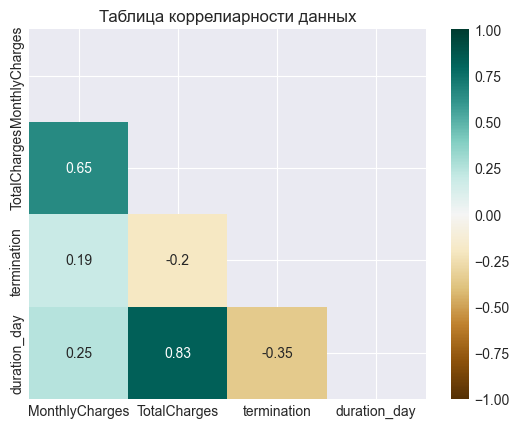

In [43]:
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Таблица коррелиарности данных')
plt.show()

<div class="alert alert-block alert-info">
Большего всего коррелируют между собой признаки продолжительности договора и сумма потраченных средств. Это понятно, чем больше пользуешься, тем больше в итоге выходит общая сумма затрат.</div>

In [44]:
data.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'termination', 'duration_day']


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,termination,service,duration_day
customerID,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BeginDate,1.0,1.000000,0.584146,0.766249,0.081447,0.456389,0.421886,0.819265,0.011268,0.050862,...,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.428109,0.495211,0.168186,0.995271
EndDate,1.0,0.584146,1.000000,0.357462,0.156832,0.212169,0.319733,0.249842,0.000000,0.123124,...,0.139392,0.068364,0.051336,0.134227,0.050373,0.047014,0.034949,1.000000,0.214208,0.408477
Type,1.0,0.766249,0.357462,1.000000,0.106860,0.277462,0.388444,0.505287,0.000000,0.086231,...,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.251639,0.449083,0.664660
PaperlessBilling,1.0,0.081447,0.156832,0.106860,1.000000,0.370495,0.467812,0.205901,0.000000,0.242133,...,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.295754,0.200406,0.000000
PaymentMethod,1.0,0.456389,0.212169,0.277462,0.370495,1.000000,0.399526,0.350460,0.000000,0.292725,...,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.449125,0.273690,0.375115
MonthlyCharges,1.0,0.421886,0.319733,0.388444,0.467812,0.399526,1.000000,0.762889,0.008175,0.304985,...,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.360050,0.889359,0.411191
TotalCharges,1.0,0.819265,0.249842,0.505287,0.205901,0.350460,0.762889,1.000000,0.000000,0.148755,...,0.544407,0.655082,0.671222,0.565910,0.659672,0.666350,0.605753,0.279152,0.484006,0.842175
gender,1.0,0.011268,0.000000,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,...,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,1.0,0.050862,0.123124,0.086231,0.242133,0.292725,0.304985,0.148755,0.000000,1.000000,...,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.233432,0.112707,0.028663


interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'termination', 'duration_day']


interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'termination', 'duration_day']


Text(0.5, 1.0, 'Таблица коррелиарности категориальных данных')

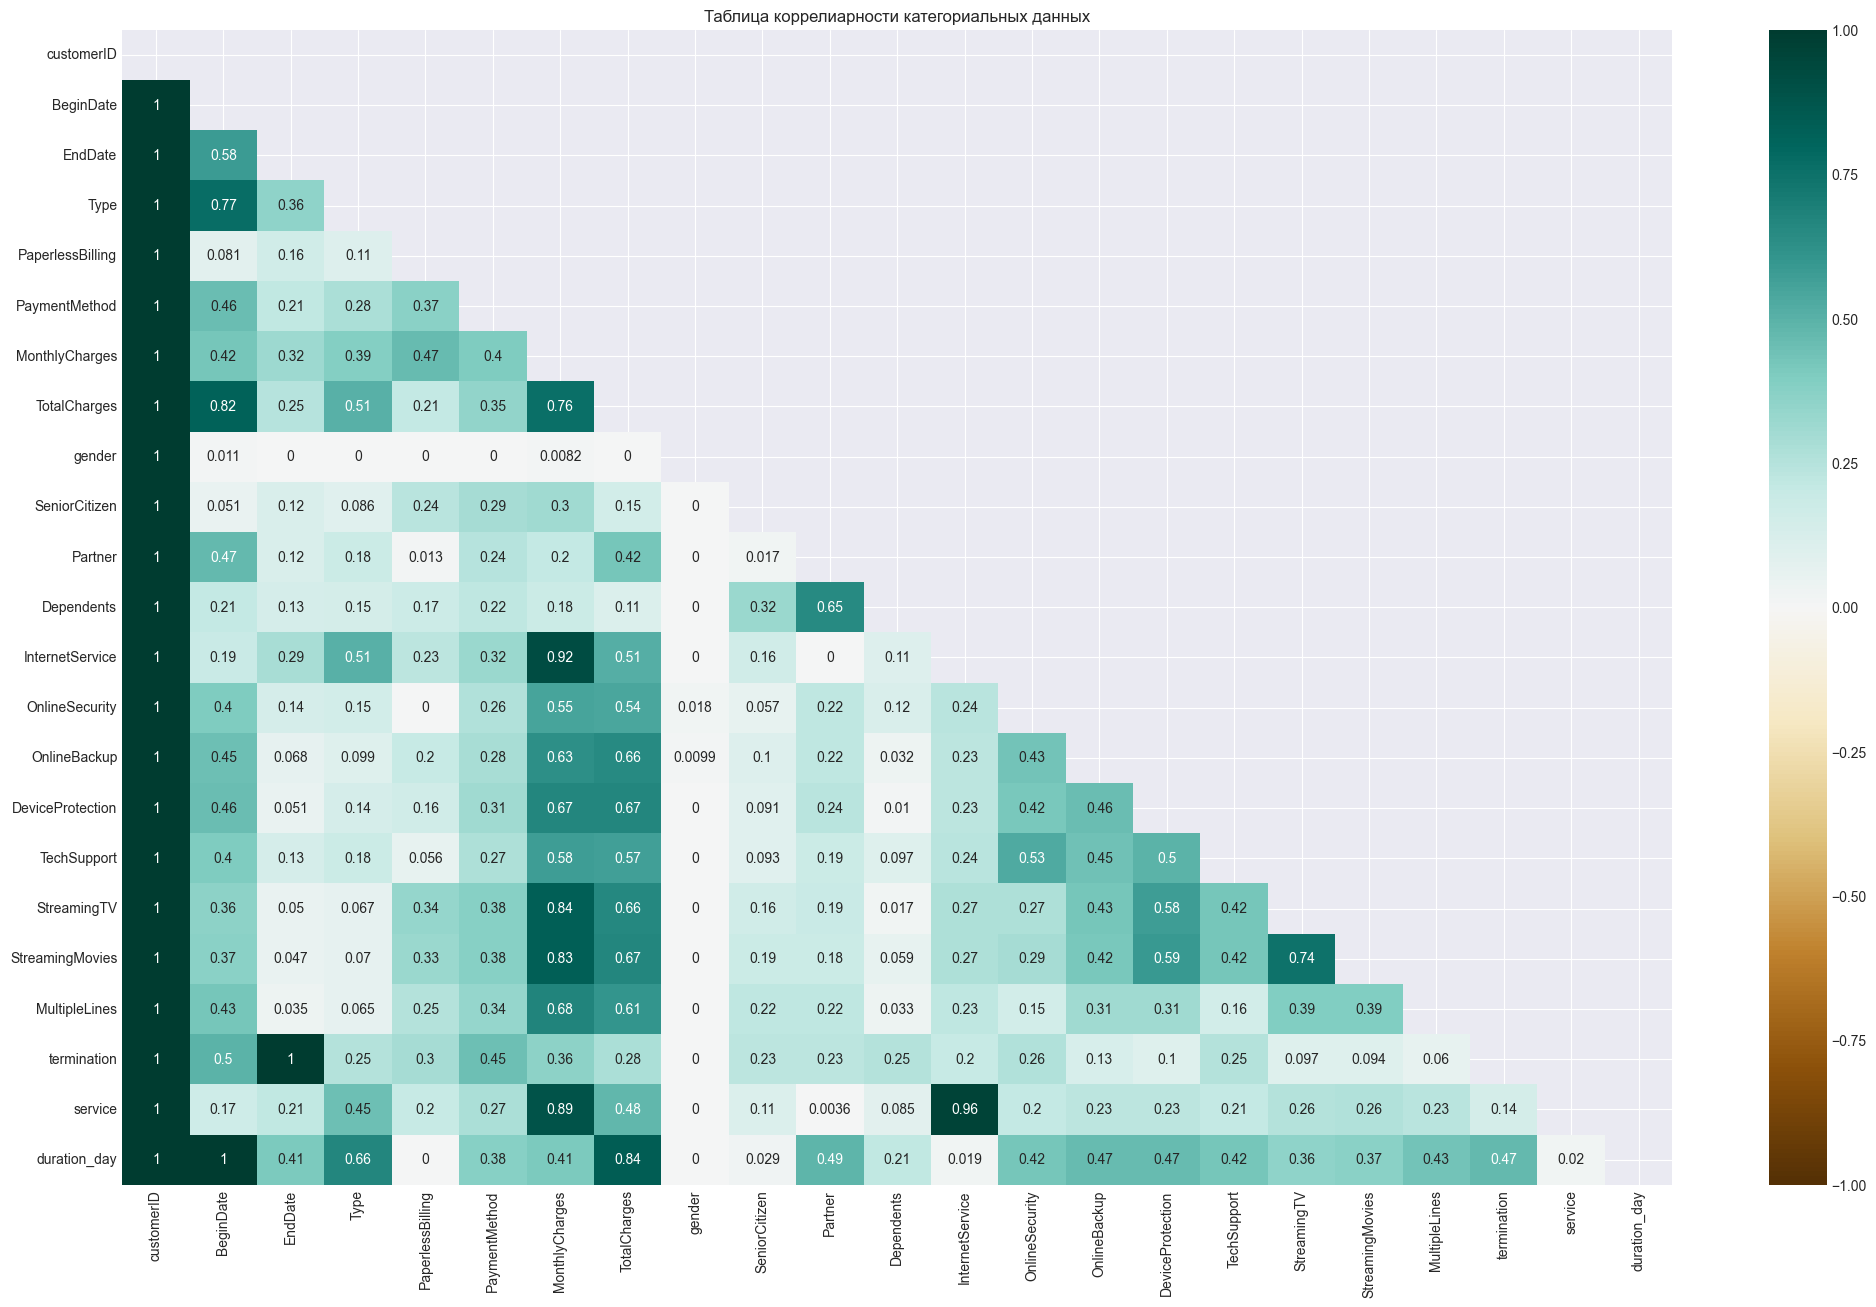

In [45]:
mask_2 = np.triu(np.ones_like(data.phik_matrix(), dtype=np.bool)) 
fig_2, ax_3 = plt.subplots(figsize=(25,15))
heatmap_2 = sns.heatmap(data.phik_matrix(), mask=mask_2, vmin=-1, vmax=1, annot=True, cmap='BrBG', ax=ax_3)
heatmap_2.set_title('Таблица коррелиарности категориальных данных')

<div class="alert alert-block alert-info">
Как видим из таблицы корреляции, есть высокие значения.   
Удалим столбцы, корреляция которых более 0.8 между численными признаками, а также столбец gender, так как он никак не влияет на целево признак
</div>

## Подготовим данные для ML моделей и проведем обучение 

Удалим столбец с полом пользователей, так как он не несет полезной информации.  
Также столбцы с датами начала и конца договора услуг, ведь эта информация хранится в столбце "duration_month".  
А также столбец 'TotalCharges' из-за высоко корреляции

In [47]:
features = data.drop(['BeginDate', 'EndDate', 'termination', 'customerID', 'service', 'gender', 'TotalCharges'], axis=1)

In [48]:
target = data['termination']

In [49]:
numerical = [c for c in features.select_dtypes(include=[np.number])]
categorical = [c for c in features.select_dtypes(include=[object])]

In [50]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=rs)

Создадим препроцессор для пайпалайна  

In [139]:
numeric_transform = StandardScaler()

categorical_transform_ohe = OneHotEncoder(handle_unknown='infrequent_if_exist', drop = 'first')

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transform, numerical),
        ('cat', categorical_transform_ohe, categorical)
    ]
)
   


Создадим пайплайны для подбора лучше модели

In [140]:
cv = KFold(n_splits=8, shuffle=True)

# Пайплайн для модели Logisticregression
pipline_1 = Pipeline((
    ('preprocessor', preprocessor),
    ('Logisticregression', LogisticRegression(random_state = rs)),
))

# Пайплайн для модели RandomForestClassifier
pipline_2 = Pipeline((
    ('preprocessor', preprocessor),
    ('RandomForestClassifier', RandomForestClassifier(random_state = rs)),
))

# Пайплайн для модели CatBoostClassifier
pipline_3 = Pipeline((
    ('CatBoost', CatBoostClassifier(cat_features=categorical,  random_state = rs)),
))

# Пайплайн для модели LGBMClassifier

pipline_4 = Pipeline((
   ('preprocessor', preprocessor),
   ('LGBMClassifier', LGBMClassifier()),
))


Параметры для каждой модели

In [142]:
# Парамаетры для Logisticregression
param_1 = {}
param_1['Logisticregression__solver'] = ['lbfgs']
param_1['Logisticregression__n_jobs'] = [-1]

# Парамаетры для RandomForestClassifier
param_2 = {}
param_2['RandomForestClassifier__max_depth'] = [10, 15, 20]
param_2['RandomForestClassifier__n_estimators'] = [10, 50, 100]
param_2['RandomForestClassifier__min_samples_split'] = [2, 10]
param_2['RandomForestClassifier__min_samples_leaf'] = [2, 10]

# Парамаетры для CatBoostClassifier
param_3 = {}
param_3['CatBoost__depth'] = [3, 5, 10]
param_3['CatBoost__learning_rate'] = [ 0.1, 0.5]
param_3['CatBoost__iterations'] = [500, 800]
param_3['CatBoost__l2_leaf_reg'] = [4, 5]
param_3['CatBoost__thread_count'] = [-1]
param_3['CatBoost__silent'] = [True]


# Парамаетры для LGBMClassifier
param_4 = {}
param_4['LGBMClassifier__learning_rate'] = [0.01, 0.1, 0.5]
param_4['LGBMClassifier__n_estimators'] = [500, 800]
param_4['LGBMClassifier__min_child_samples'] = [10, 50, 100]



In [143]:
pars = [param_1, param_2, param_3, param_4]
pips = [pipline_1, pipline_2, pipline_3, pipline_4]

В цикле переберем и выведем лучшие параметры для 4 моделей

In [122]:
for i in range(len(pars)):
    gs = GridSearchCV(pips[i], pars[i], n_jobs=-1, cv=cv, scoring='roc_auc')
    gs.fit(features_train, target_train)
    print(f'Лучшие параметры GridSearch модели № {i+1}:')
    display(gs.best_params_)
    print('Лучший "auc-roс на train:', gs.best_score_.round(4))
    print('')
    print('<======================================================>')
    print('')
    


Лучшие параметры GridSearch модели № 1:


{'Logisticregression__n_jobs': -1, 'Logisticregression__solver': 'lbfgs'}

Лучший "auc-roс на train: 0.85

<======================================================>

Лучшие параметры GridSearch модели № 2:


{'RandomForestClassifier__max_depth': 10,
 'RandomForestClassifier__min_samples_leaf': 2,
 'RandomForestClassifier__min_samples_split': 10,
 'RandomForestClassifier__n_estimators': 100}

Лучший "auc-roс на train: 0.8658

<======================================================>

Лучшие параметры GridSearch модели № 3:


{'CatBoost__depth': 3,
 'CatBoost__iterations': 500,
 'CatBoost__l2_leaf_reg': 4,
 'CatBoost__learning_rate': 0.5,
 'CatBoost__silent': True,
 'CatBoost__thread_count': -1}

Лучший "auc-roс на train: 0.9344

<======================================================>

Лучшие параметры GridSearch модели № 4:


{'LGBMClassifier__learning_rate': 0.1,
 'LGBMClassifier__min_child_samples': 10,
 'LGBMClassifier__n_estimators': 500}

Лучший "auc-roс на train: 0.9103

<======================================================>



По результатам GridSearchCV на train, мы получили следующие результаты метрики ROC-AUC:  
LogisticRegression - 0.8499  
RandomForestClassifier - 0.8659  
CatBoostClassifier - 0.933  
LGBMClassifier - 0.911  

Для валидациии на тестовой выборки, используем модель CatBoostClassifier со следующими параметрами:  
depth : 3,  
iterations : 500,  
l2_leaf_reg : 4,  
learning_rate : 0.5,  
silent : True,  
thread_count : -1  

Для оптимизации кода (не запускать обучение заново), используем параметр GridSearchCV - best_estimator_ для расчета метрики ROC-AUC на тестовой выборке и построения графика важности

In [134]:
cat_model = CatBoostClassifier(learning_rate=0.5, iterations=500, depth=3, l2_leaf_reg=4, thread_count=-1, random_state=rs)
cat_model.fit(features_train, target_train, cat_features=categorical, verbose=10)

0:	learn: 0.5029334	total: 29.2ms	remaining: 14.5s
10:	learn: 0.3853911	total: 412ms	remaining: 18.3s
20:	learn: 0.3586067	total: 799ms	remaining: 18.2s
30:	learn: 0.3358256	total: 1.18s	remaining: 17.9s
40:	learn: 0.3170291	total: 1.63s	remaining: 18.2s
50:	learn: 0.3072835	total: 2s	remaining: 17.6s
60:	learn: 0.2863952	total: 2.37s	remaining: 17s
70:	learn: 0.2767251	total: 2.74s	remaining: 16.5s
80:	learn: 0.2641623	total: 3.13s	remaining: 16.2s
90:	learn: 0.2572626	total: 3.49s	remaining: 15.7s
100:	learn: 0.2485575	total: 3.86s	remaining: 15.3s
110:	learn: 0.2376391	total: 4.22s	remaining: 14.8s
120:	learn: 0.2327128	total: 4.59s	remaining: 14.4s
130:	learn: 0.2306243	total: 4.95s	remaining: 13.9s
140:	learn: 0.2276671	total: 5.33s	remaining: 13.6s
150:	learn: 0.2247769	total: 5.7s	remaining: 13.2s
160:	learn: 0.2209043	total: 6.1s	remaining: 12.8s
170:	learn: 0.2175652	total: 6.47s	remaining: 12.4s
180:	learn: 0.2159683	total: 6.84s	remaining: 12.1s
190:	learn: 0.2106988	total: 

In [135]:
predict_proba = cat_model.predict_proba(features_test)[:, 1]
auc_roc = roc_auc_score(target_test, predict_proba).round(4)
print('Метрика ROC-AUC на тестовой выборке:')
auc_roc

Метрика ROC-AUC на тестовой выборке:


0.9224

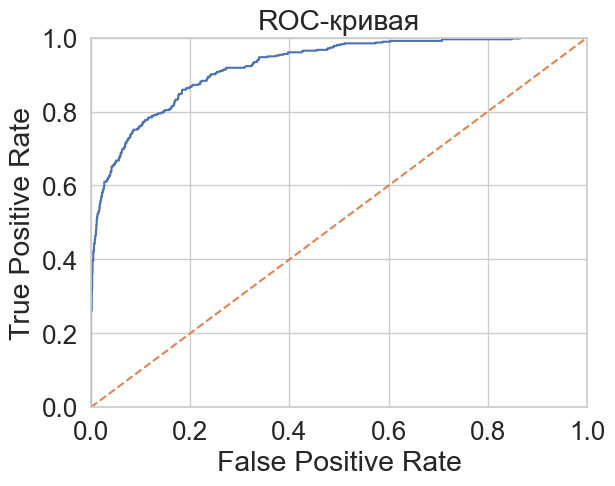

In [136]:
fpr, tpr, thresholds = roc_curve(target_test, predict_proba) 
 
plt.figure() 
 
plt.plot(fpr, tpr) 

plt.plot([0, 1], [0, 1], linestyle='--') 
 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0]) 

plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
 
plt.title('ROC-кривая') 
plt.show()

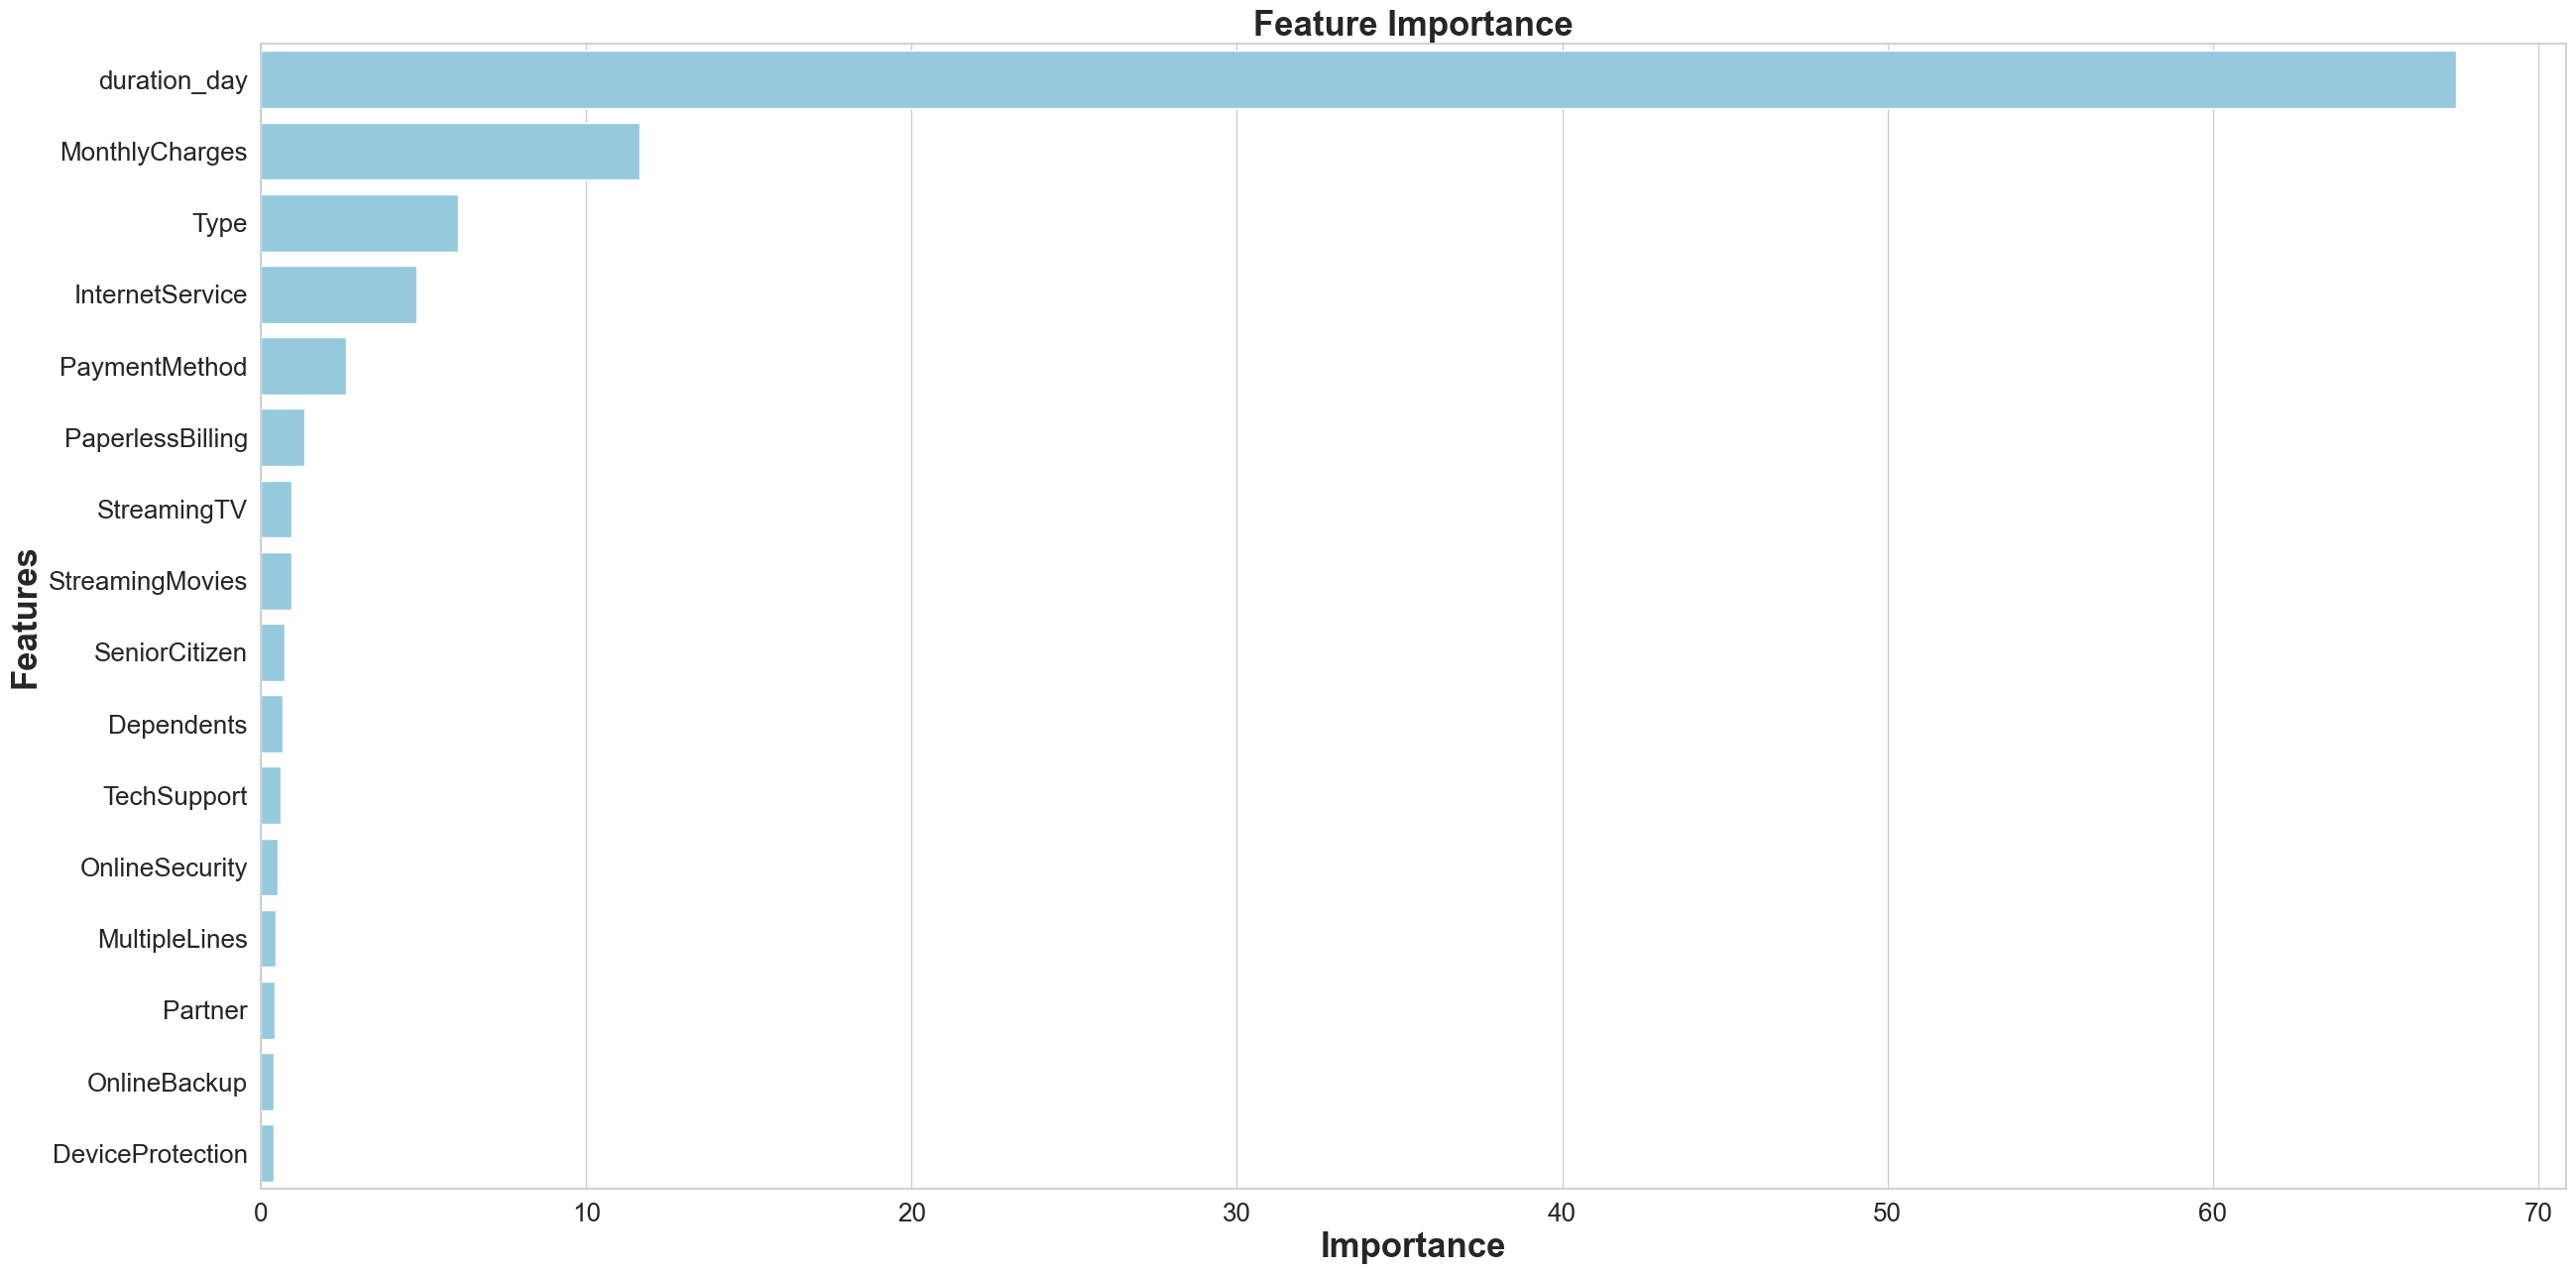

None

,Features,Gini-Importance
0,duration_day,67.487935
1,MonthlyCharges,11.635182
2,Type,6.064234
3,InternetService,4.789181
4,PaymentMethod,2.625405
5,PaperlessBilling,1.347950
6,StreamingTV,0.936698
7,StreamingMovies,0.930116
8,SeniorCitizen,0.729534
9,Dependents,0.656497


In [137]:
feats = {}
for feature, importance in zip(features.columns, cat_model.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30,15)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

<div class="alert alert-block alert-info">
Как видно из графика и таблицы значимости признаков, наиболее важными являются срок сотрудничества, сумма затраченных средств и тип оплаты, что подтверждает наши мысли в части исследовательского анализа данных
</div>

Создадим матрицу ошибок

In [138]:
predict = cat_model.predict(features_test)
matrix_error = pd.DataFrame(confusion_matrix(target_test, predict))
print('Матрица ошибок:', matrix_error)

Матрица ошибок:       0    1
0  1233   74
1   150  304


<div class="alert alert-block alert-info">
Как видим из матрицы ошибок - модель предсказала ложноотрицательные ответы (FN) 150 раз, то есть когда клиент не собирался прекращать сотрудничество, наша модель предсказала, что клиент уйдет.  И 74 раз наоборот, когда клиент собирался уйти, но модель предсказала, что пользователь не собирается прекращать сотрудничество. Можно утверждать, что наша модель немного пессемистична, однако 1233 и 304 правильно предсказанных ответов подтверждают метрику AUC-ROC (0,9224), о хорошом качестве работы модели
</div>

**Вывод:**  
Была проделена работа по объединению выборок в единый датафрейм. Проведена предобработка данных, добавльнение новых признаков, удаление неинформативных.  


Проведен исследовательский анализ данных, в ходе которого было выявлено, что большинство клиентов, прекративших пользовться услугами, уходили в первые 2 года и платили более высокую ежемесячную плату, чем оставшиеся пользоваться услугами компании клиенты. Также ключевым фактором является и тип оплаты услуг. Большая часть клиентов, прекратившиеся пользоваться услугами, платили ежемесячную плату.Скорей всего, именно поэтому их плата была такой высокой, и следовательно и срок сотрудничества таким небольшим.  

После анализа, был выбран тип ML моделей, подготовка данных к обучению с последующим тестированием на выборке. Наилучший показатель был у модели CatBoost с качеством метрики AUC-ROC 0.9224, что является хорошим результатом

# Отчет по выполненной работе

Все пункты плана выполнены, помимо кодирования признаков. Оно не понадобилось из-за особенностей моделей, на котором проводилась работа

1. Предобработка данных  
   1.1. Загрузка данных  
   1.2. Предварительны анализ данных  
   1.3. Объединение в единый фрейм, изучение полученных данных, определение возможных причин пропусков  
2. Исследовательский анализ данных, подготовка данных к расчету модели: удаление неинформативных признаков, кодирование категориальных переменных
3. Обучение моделей: подготовка выборок для обучения, подбор гиперпараметров
4. Проверка качества моделей на кросс-валидации, определение на тестовой выборке метрики AUC-ROC для лучшей модели, изучение важности признаков лучшей модели
5. Общий вывод

Был создан дополнительный столбец "duration_day" для увеличения качества входных признаков. Данный признак обозначает кол-во дней пользования клиентами услугами компании. Получен из разности двух столбцов 'BeginDate' и 'EndDate'. Также у признакв SeniorCitizen (наличие пенсионного статуса) поменяли тип данных, для передачи в ML модели, как категориального признака. Были удалены признаки TotalCharges (из-за выосокой коррелиарности с признаком duration_day), gender и customerID из-за неинформативности признаков в целях ускорить работу модели